In [1]:
from scipy.special import roots_jacobi, eval_jacobi
from sympy import symbols, diff
import numpy as np
import scipy
import math

In [2]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

## Compute Coordinates:

In [3]:
coord_x = np.array([0, 0.5, 1, 1.5, 2, 4, 6, 7, 8, 9, 10, 10.5, 11, 11.5, 12])
coord_y = np.array([0, 1, 2, 4, 6, 7, 8])

In [4]:
L_x = coord_x[-1] # Denotes total length in [0, L]
M_x = len(coord_x) - 1 # Denotes number of elements
L_y = coord_y[-1]
M_y = len(coord_y) - 1

In [5]:
def corners_2d(x_array, y_array):
    return(np.meshgrid(x_array, y_array))

In [6]:
def array_2d(M_x, M_y, npts):
    return(np.zeros((M_y, M_x, npts, npts)))

In [7]:
# Note range_in denotes endpoints of x, y coordinate arrays:

def int_points(range_in, npts, M_value):

    p_order = npts - 1
    xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
    GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))
    GLL_dist = np.array([np.abs(GLL_points[0] - value) for value in GLL_points])
    
    return_array = np.zeros([M_value, npts])
    
    for i in np.arange(M_value):
        array = np.array([range_in[i]])
        dist = range_in[i + 1] - range_in[i]
        
        for j in GLL_dist[1:]: 
            scaled_point = ((j / 2) * (dist)) + range_in[i] # Note: 2 here is the distance from -1 to 1
            array = np.concatenate((array, np.array([scaled_point])))
            
        return_array[i, :] = array
    
    return(return_array)

In [8]:
# Returns 2 (M_y, M_x, npts, npts) arrays - the 0 index contains the x value; the 1 index contains the y value:

def coords_2d(coord_x, coord_y, npts, M_x, M_y):
    
    p_order = npts - 1
    xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
    GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))
    GLL_dist = np.array([np.abs(GLL_points[0] - value) for value in GLL_points])
    
    Lx_array = int_points(coord_x, npts, M_x)
    Ly_array = int_points(coord_y, npts, M_y)
    return_array_x = array_2d(M_x, M_y, npts)
    return_array_y = array_2d(M_x, M_y, npts)
    
    x_i = 0
    for elem_1 in Lx_array:
        y_i = 0
        for elem_2 in Ly_array:
            return_array_x[y_i, x_i, :, :] = np.meshgrid(elem_1, elem_2)[0]
            return_array_y[y_i, x_i, :, :] = np.meshgrid(elem_1, elem_2)[1]
            
            y_i += 1
        x_i += 1
    
    return(return_array_x, return_array_y)

## Initialize Gaussian Field:

In [9]:
# Returns 2D normalized Gaussian scalar field; sigma denotes the spread in the x, y directions: 
# Eq. 10 from https://mathworld.wolfram.com/GaussianFunction.html

def norm_Gaussian_2d(coords_2d, array_2d, sigma, L_x, L_y, M_x, M_y):
    
    numerator_x = np.exp(-(coords_2d[0] - (L_x / 2))**2 / (2 * sigma[0]**2))
    numerator_y = np.exp(-(coords_2d[1] - (L_y / 2))**2 / (2 * sigma[1]**2))
    denominator = (sigma[0] * sigma[1]) * (2 * np.pi)
    
    return((numerator_x * numerator_y) / denominator)

In [10]:
def dx_Gaussian_2d(coords_2d, array_2d, sigma, L_x, L_y, M_x, M_y):
    t_1 = norm_Gaussian_2d(coords_2d, array_2d, sigma, L_x, L_y, M_x, M_y)
    
    # t_2 is the term which emerges from chain rule on the exponent 
    t_2 = -(1 / (2 * (sigma[0]**2))) * ((2 * coords_2d[0]) - (2 * (L_x / 2)))
    
    return(t_1 * t_2)

In [11]:
def dy_Gaussian_2d(coords_2d, array_2d, sigma, L_x, L_y, M_x, M_y):
    t_1 = norm_Gaussian_2d(coords_2d, array_2d, sigma, L_x, L_y, M_x, M_y)
    
    # t_2 is the term which emerges from chain rule on the exponent
    t_2 = -(1 / (2 * (sigma[1]**2))) * ((2 * coords_2d[1]) - (2 * (L_y / 2)))
    
    return(t_1 * t_2)

### 2D Plotting:

In [12]:
npts = 6

x_in = coords_2d(coord_x, coord_y, npts, M_x, M_y)[0].transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts)
y_in = coords_2d(coord_x, coord_y, npts, M_x, M_y)[1].transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts)

In [13]:
init = norm_Gaussian_2d(coords_2d(coord_x, coord_y, npts, M_x, M_y), array_2d(M_x, M_y, npts), 
                        [1, 1], L_x, L_y, M_x, M_y)

init_dx = dx_Gaussian_2d(coords_2d(coord_x, coord_y, npts, M_x, M_y), array_2d(M_x, M_y, npts), 
                        [1, 1], L_x, L_y, M_x, M_y)

init_dy = dy_Gaussian_2d(coords_2d(coord_x, coord_y, npts, M_x, M_y), array_2d(M_x, M_y, npts), 
                        [1, 1], L_x, L_y, M_x, M_y)

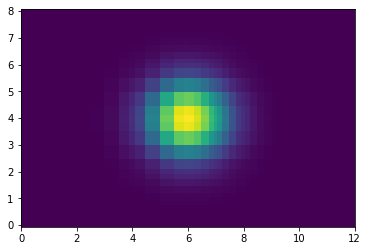

In [244]:
plt.pcolormesh(x_in, y_in, 
               init.transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts), 
               cmap='viridis', shading='auto')

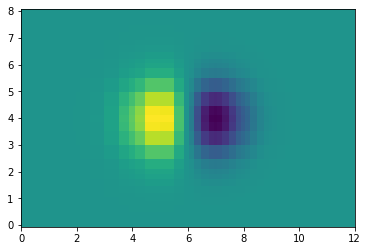

In [245]:
plt.pcolormesh(x_in, y_in, 
               init_dx.transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts), 
               cmap='viridis', shading='auto')


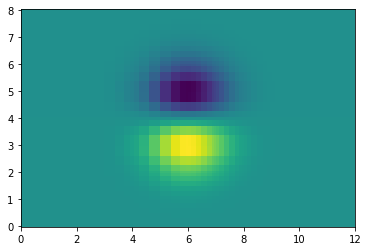

In [230]:
plt.pcolormesh(x_in, y_in, 
               init_dy.transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts), 
               cmap='viridis', shading='auto')

## Define Derivative Operator for Reference Element:

In [14]:
def vandermonde(npts_values, return_type):
    # For the monomial basis: 
    if return_type == 'Monomial':
        return(np.vander(npts_values, increasing = True))
    elif return_type == 'Legendre':
        return(np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1))

In [15]:
def Ld_vandermonde(npts_values): 
    
    LP = np.polynomial.legendre
    v_matrix = np.polynomial.legendre.legvander(npts_values, len(npts_values)-1)
    d_v_matrix = np.zeros_like(v_matrix)

    for i in range(len(npts_values)):
        # Coefficients for the i-th Legendre polynomial (e.g., [0, 0, 1] for P_2)
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = 1

        # Compute the derivative of the i-th Legendre polynomial
        deriv_coeffs = LP.legder(coeffs, m=1) # m=1 for first derivative

        # Evaluate the derivative at the points x
        d_v_matrix[:, i] = LP.legval(npts_values, deriv_coeffs)
        
    return(d_v_matrix)

In [16]:
def return_D(V1, V2):
    return(np.matmul(V2, np.linalg.inv(V1)))

In [17]:
npts = 6
p_order = npts - 1
xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))

In [18]:
V1 = vandermonde(GLL_points, 'Legendre')
V2 = Ld_vandermonde(GLL_points)
D = return_D(V1, V2)

## Define Derivative Mapping Matrix:

In [19]:
coord_x_dist = np.array([np.abs(coord_x[i + 1] - coord_x[i]) for i in np.arange(M_x)])
coord_y_dist = np.array([np.abs(coord_y[i + 1] - coord_y[i]) for i in np.arange(M_y)])

In [20]:
# Note 1: the function below forms the Jacobian matrix 
# Note 2: the map will change element to element due to variations in element areas

def d_rmap(j, i, coord_x_dist, coord_y_dist):
    
    return_array = np.zeros([2, 2])
    
    return_array[0, 0] = ((coord_x_dist)[i]) / 2
    return_array[1, 1] = ((coord_y_dist)[j]) / 2
    return_array[0, 1] = 0
    return_array[1, 0] = 0
    
    return(return_array)

In [21]:
# Returns d_rmap for each element:
def d_rmap_array(M_y, M_x, coord_x_dist, coord_y_dist):
    
    return_array = np.zeros([M_y, M_x, 2, 2])
    for i in np.arange(M_x):
        for j in np.arange(M_y):
            return_array[j, i, :, :] = d_rmap(j, i, coord_x_dist, coord_y_dist)
            
    return(return_array)

## Write operators:

In [22]:
def pd_y(array_in, D):
    return(np.matmul(D, array_in))

In [23]:
def pd_x(array_in, D, M_x, M_y):
    # Arrays are populated across, so loop over x (columns) first: 
    array_transpose = np.array([[array_in[j, i].transpose() for i in np.arange(M_x)] for j in np.arange(M_y)])
    dx_array = np.matmul(D, array_transpose)
    
    # Return a transposed array:
    return(np.array([[dx_array[j, i].transpose() for i in np.arange(M_x)] for j in np.arange(M_y)]))

In [24]:
# Returns quantity w_i * w_j * J_ij for each GLL node: 

def W_matrix(quad_weights, M_x, M_y, npts, coord_x_dist, coord_y_dist):
    
    return_array = np.zeros([M_y, M_x, npts, npts])
    
    for i in np.arange(M_x):
        for j in np.arange(M_y):
            J_value = np.linalg.det(d_rmap(j, i, coord_x_dist, coord_y_dist))
            return_array[j, i, :, :] = J_value * np.outer(quad_weights, quad_weights)
            
    return(return_array)

In [25]:
# In the interior, the projected divergence is equal to the discontinuous divergence
# At boundaries, the projected divergence requires taking Jacobian weighted averaging 

def proj_2D(array_in, M_x, M_y, npts, quad_weights, coord_x_dist, coord_y_dist):
    
    return_array = np.zeros([M_y, M_x, npts, npts])
    W_array = W_matrix(quad_weights, M_x, M_y, npts, coord_x_dist, coord_y_dist)
    
    for i in np.arange(M_x):
        i_l = (i - 1) % M_x
        i_r = (i + 1) % M_x
        
        for j in np.arange(M_y):
            j_u = (j - 1) % M_y
            j_d = (j + 1) % M_y 
            
            return_array[j, i, :, :] = array_in[j, i, :, :]
            
            # Projection applied to edges:
            return_array[j, i, 0, :] = ((array_in[j, i, 0, :] * W_array[j, i, 0, :]) + (array_in[j_u, i, -1, :] * W_array[j_u, i, -1, :])) / (W_array[j, i, 0, :] + W_array[j_u, i, -1, :]) 
            return_array[j, i, -1, :] = ((array_in[j_d, i, 0, :] * W_array[j_d, i, 0, :]) + (array_in[j, i, -1, :] * W_array[j, i, -1, :])) / (W_array[j_d, i, 0, :] + W_array[j, i, -1, :])
            
            return_array[j, i, :, 0] = ((array_in[j, i, :, 0] * W_array[j, i, :, 0]) + (array_in[j, i_l, :, -1] * W_array[j, i_l, :, -1])) / (W_array[j, i, :, 0] + W_array[j, i_l, :, -1])
            return_array[j, i, :, -1] = ((array_in[j, i, :, -1] * W_array[j, i, :, -1]) + (array_in[j, i_r, :, 0] * W_array[j, i_r, :, 0])) / (W_array[j, i, :, -1] + W_array[j, i_r, :, 0])
            
            # Projection applied to corners:
            return_array[j, i, 0, 0] = ((array_in[j, i, 0, 0] * W_array[j, i, 0, 0]) + (array_in[j_u, i, -1, 0] * W_array[j_u, i, -1, 0]) + (array_in[j, i_l, 0, -1] * W_array[j, i_l, 0, -1]) + (array_in[j_u, i_l, -1, -1] * W_array[j_u, i_l, -1, -1])) / (W_array[j, i, 0, 0] + W_array[j_u, i, -1, 0] + W_array[j, i_l, 0, -1] + W_array[j_u, i_l, -1, -1]) 
            return_array[j, i, 0, -1] = ((array_in[j, i, 0, -1] * W_array[j, i, 0, -1]) + (array_in[j, i_r, 0, 0] * W_array[j, i_r, 0, 0]) + (array_in[j_u, i, -1, -1] * W_array[j_u, i, -1, -1]) + (array_in[j_u, i_r, -1, 0] * W_array[j_u, i_r, -1, 0])) / (W_array[j, i, 0, -1] + W_array[j, i_r, 0, 0] + W_array[j_u, i, -1, -1] + W_array[j_u, i_r, -1, 0])
            return_array[j, i, -1, 0] = ((array_in[j, i, -1, 0] * W_array[j, i, -1, 0]) + (array_in[j_d, i, 0, 0] * W_array[j_d, i, 0, 0]) + (array_in[j_d, i_l, 0, -1] * W_array[j_d, i_l, 0, -1]) + (array_in[j, i_l, -1, -1] * W_array[j, i_l, -1, -1])) / (W_array[j, i, -1, 0] + W_array[j_d, i, 0, 0] + W_array[j_d, i_l, 0, -1] + W_array[j, i_l, -1, -1])
            return_array[j, i, -1, -1] = ((array_in[j, i, -1, -1] * W_array[j, i, -1, -1]) + (array_in[j_d, i, 0, -1] * W_array[j_d, i, 0, -1]) + (array_in[j_d, i_r, 0, 0] * W_array[j_d, i_r, 0, 0]) + (array_in[j, i_r, -1, 0] * W_array[j, i_r, -1, 0])) / (W_array[j, i, -1, -1] + W_array[j_d, i, 0, -1] + W_array[j_d, i_r, 0, 0] + W_array[j, i_r, -1, 0])
            
    return(return_array)
                                          

### Gradient (returns a vector in [x_2, y_2]):

In [26]:
# Returns gradient values in the (x_2, y_2) domain; [0] index is the ith component and [1] index is the jth component:

def grad(array_in, D, M_x, M_y, npts, coord_x_dist, coord_y_dist):
    
    grad_x = np.zeros_like(array_in)
    grad_y = np.zeros_like(array_in)
    
    # Returns partial derivatives computed within the reference element:
    G_dx = pd_x(array_in, D, M_x, M_y)
    G_dy = pd_y(array_in, D)
    
    for i in np.arange(M_x):
        for j in np.arange(M_y):
            for k_1 in np.arange(npts):
                for k_2 in np.arange(npts):
                    # Write vector of form [dG / dx_1, dG / dy_1]:
                    v_in = np.array([G_dx[j, i, k_1, k_2], G_dy[j, i, k_1, k_2]])
                    
                    # Write matrix for derivative mapping:
                    d_r = d_rmap(j, i, coord_x_dist, coord_y_dist)
                    
                    # Map the gradient vector to the physical domain:
                    grad_x[j, i, k_1, k_2] = np.matmul(np.linalg.inv(d_r).transpose(), v_in)[0]
                    grad_y[j, i, k_1, k_2] = np.matmul(np.linalg.inv(d_r).transpose(), v_in)[1]
                    
    return(grad_x, grad_y)

### Check:

In [27]:
grad_gaussian = grad(init, D, M_x, M_y, npts, coord_x_dist, coord_y_dist)

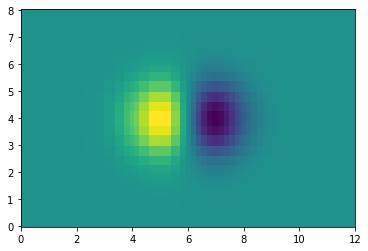

In [237]:
plt.pcolormesh(x_in, y_in, grad_gaussian[0].transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts), 
               cmap='viridis', shading='auto')

### Divergence (converts a vector from [x_2, y_2] to contravariant form):

In [28]:
# Assumes vector field input is within the computational domain: [0, Ly] x [0, Lx]

def div(x_comp_in, y_comp_in, M_x, M_y, npts, coord_x_dist, coord_y_dist):
        
    det_J = np.zeros([M_y, M_x])
    contra_x = np.zeros_like(x_comp_in)
    contra_y = np.zeros_like(y_comp_in)
    
    # Convert to contravariant vector:
    for i in np.arange(M_x):
        for j in np.arange(M_y):
            det_J[j, i] = np.linalg.det(d_rmap(j, i, coord_x_dist, coord_y_dist))
            
            for k_1 in np.arange(npts):
                for k_2 in np.arange(npts):   
                    # Write vector of form [x_2, y_2]:
                    v_in = np.array([x_comp_in[j, i, k_1, k_2], y_comp_in[j, i, k_1, k_2]])
        
                    # Write matrix for derivative mapping:
                    d_r = d_rmap(j, i, coord_x_dist, coord_y_dist)
                
                    # Convert to contravariant form:
                    contra_x[j, i, k_1, k_2] = np.matmul(np.linalg.inv(d_r), v_in)[0]
                    contra_y[j, i, k_1, k_2] = np.matmul(np.linalg.inv(d_r), v_in)[1]
        
    # Implement divergence formula from Heinbockel, pg. 175; Apply D to contra_x, contra_y:
    A_dx = pd_x(contra_x, D, M_x, M_y)
    A_dy = pd_y(contra_y, D)
    
    return((1 / det_J[:, :, None, None]) * ((det_J[:, :, None, None] * A_dx) + (det_J[:, :, None, None] * A_dy)))

### Check:

In [33]:
x_comp = grad(init, D, M_x, M_y, npts, coord_x_dist, coord_y_dist)[0]
y_comp = grad(init, D, M_x, M_y, npts, coord_x_dist, coord_y_dist)[1]

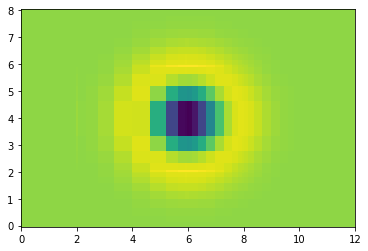

In [34]:
# Laplacian of the Gaussian: 

plt.pcolormesh(x_in, y_in, 
               div(x_comp, y_comp, M_x, M_y, npts, coord_x_dist, coord_y_dist).transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts), 
               cmap='viridis', shading='auto')

In [35]:
# Analytic solution:

def laplacianx_Gaussian_2d(coords_2d, array_2d, sigma, L_x, L_y, M_x, M_y):
    t_1 = norm_Gaussian_2d(coords_2d, array_2d, sigma, L_x, L_y, M_x, M_y) 
    t_2 = (-(1 / (2 * (sigma[0]**2))) * ((2 * coords_2d[0]) - (2 * (L_x / 2)))) ** 2
    return((t_1 * t_2) + (t_1 * (-1 / (sigma[0]**2) ** 2)))

In [36]:
def laplaciany_Gaussian_2d(coords_2d, array_2d, sigma, L_x, L_y, M_x, M_y):
    t_1 = norm_Gaussian_2d(coords_2d, array_2d, sigma, L_x, L_y, M_x, M_y) 
    t_2 = (-(1 / (2 * (sigma[1]**2))) * ((2 * coords_2d[1]) - (2 * (L_y / 2)))) ** 2
    return((t_1 * t_2) + (t_1 * (-1 / (sigma[1]**2) ** 2)))

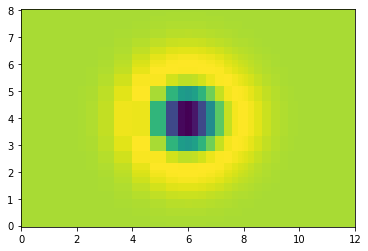

In [37]:
laplace_1 = laplacianx_Gaussian_2d(coords_2d(coord_x, coord_y, npts, M_x, M_y), 
                                   array_2d(M_x, M_y, npts), 
                                   [1, 1], L_x, L_y, M_x, M_y)

laplace_2 = laplaciany_Gaussian_2d(coords_2d(coord_x, coord_y, npts, M_x, M_y), 
                                   array_2d(M_x, M_y, npts), 
                                   [1, 1], L_x, L_y, M_x, M_y)

plt.pcolormesh(x_in, y_in, 
               (laplace_1 + laplace_2).transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts), 
               cmap='viridis', shading='auto')

### Weak Divergence:

In [29]:
def quad_weights(npts_values):
    
    # Values in f_array result from exact integration:
    f_array = np.zeros(len(npts_values))
    f_array[0] = 2
    
    # Define basis matrix for Legendre polynomials: 
    V = np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1).transpose()
    
    return(np.matmul(np.linalg.inv(V), f_array.transpose()))

In [30]:
# Returns [M_y, M_x] array with Jacobian values for each element:

def det_J(M_x, M_y, coord_x_dist, coord_y_dist):
    det_J = np.zeros([M_y, M_x])
    for i in np.arange(M_x):
        for j in np.arange(M_y):
            det_J[j, i] = np.linalg.det(d_rmap(j, i, coord_x_dist, coord_y_dist))
            
    return(det_J)

In [31]:
def weak_div(x_comp_in, y_comp_in, M_x, M_y, npts, 
             coord_x_dist, coord_y_dist, D, quad_weights):
    
    test_func = np.zeros([M_y, M_x, npts, npts])
    return_array = np.zeros([M_y, M_x, npts, npts])
    J_values = det_J(M_x, M_y, coord_x_dist, coord_y_dist)
    
    # Loop over all test functions:
    for i in np.arange(npts):
        for j in np.arange(npts):
            test_func[:, :, i, j] = 1 
  
            # Compute gradient of test functions; return a physical vector:
            test_x_comp, test_y_comp = grad(test_func, D, M_x, M_y, npts, coord_x_dist, coord_y_dist)
            
            # Compute dot product of grad_test vector and input vector:
            dot_array = J_values[:, :, None, None] * ((x_comp_in * test_x_comp) + (y_comp_in * test_y_comp))
            
            # Perform numerical integration; sum along 1st npts dim:
            quad_int_array = np.sum(np.matmul(dot_array, quad_weights) * quad_weights, axis = -1)
            return_array[:, :, i, j] = -quad_int_array
            test_func[:, :, i, j] = 0
            
    return(return_array)

In [41]:
test = weak_div(x_comp, y_comp, M_x, M_y, npts, 
                coord_x_dist, coord_y_dist, D, quad_weights(GLL_points)) / W_matrix(quad_weights(GLL_points), M_x, M_y, npts, coord_x_dist, coord_y_dist)

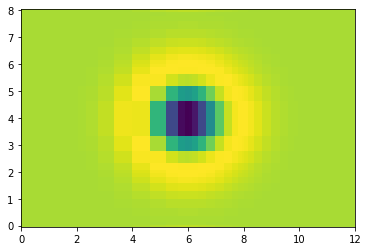

In [42]:
plt_wk_div_test = plt.pcolormesh(x_in, y_in, 
                                 proj_2D(test, M_x, M_y, npts, quad_weights(GLL_points),
                                         coord_x_dist, coord_y_dist).transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts), 
                                 cmap='viridis', shading='auto')

# plt.colorbar(plt_wk_div_test)

### Write Weak Laplacian Operator:

In [32]:
# Computed in terms of weak divergence of the gradient; returns projected array:

def weak_laplacian(array_in, D, M_x, M_y, npts, coord_x_dist, coord_y_dist, quad_weights):
    
    # Compute the gradient of the scalar inputs:
    phys_comp_x, phys_comp_y = grad(array_in, D, M_x, M_y, npts, coord_x_dist, coord_y_dist)
    weak_div_array = weak_div(phys_comp_x, phys_comp_y, M_x, M_y, 
                              npts, coord_x_dist, coord_y_dist, D, quad_weights) / W_matrix(quad_weights, M_x, M_y, npts, coord_x_dist, coord_y_dist)
    
    # Return weak divergence with projection:
    return(proj_2D(weak_div_array, M_x, M_y, npts, quad_weights, coord_x_dist, coord_y_dist))

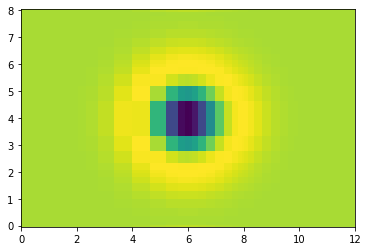

In [44]:
plt.pcolormesh(x_in, y_in,
               weak_laplacian(init, D, M_x, M_y, npts, coord_x_dist, coord_y_dist, quad_weights(GLL_points)).transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts),
               cmap='viridis', shading='auto')

### Write Weak Gradient Operator:

In [33]:
# Note: The weak gradient returns a vector in physical coordinates; test functions are in the covariant basis 

def weak_grad(array_in, D, M_x, M_y, npts, coord_x_dist, coord_y_dist, quad_weights):
    
    return_array = np.zeros([M_y, M_x, 2, npts, npts])
    J_values = det_J(M_x, M_y, coord_x_dist, coord_y_dist)
    d_r = d_rmap_array(M_y, M_x, coord_x_dist, coord_y_dist)
    dr_inv_transpose = np.array([[np.linalg.inv(d_r[j, i, :, :]).transpose() for i in np.arange(M_x)] for j in np.arange(M_y)])
    
    # Loop over all test functions:
    for k_1 in np.arange(npts):
        for k_2 in np.arange(npts):
            test_array = np.array([[1, 0], [0, 1]])
            test_comp_x = np.zeros([M_y, M_x, 2, npts, npts])
            test_comp_y = np.zeros([M_y, M_x, 2, npts, npts])
            
            # Convert to physical coordinates:
            test_comp_x[:, :, :, k_1, k_2] = np.matmul(dr_inv_transpose, test_array)[:, :, :, 0]
            test_comp_y[:, :, :, k_1, k_2] = np.matmul(dr_inv_transpose, test_array)[:, :, :, 1]                               
                              
            # Apply divergence routines:
            div_array_x = J_values[:, :, None, None] * (div(test_comp_x[:, :, 0, :, :], test_comp_x[:, :, 1, :, :], M_x, M_y, 
                                                             npts, coord_x_dist, coord_y_dist) * array_in)
            
            div_array_y = J_values[:, :, None, None] * (div(test_comp_y[:, :, 0, :, :], test_comp_y[:, :, 1, :, :], M_x, M_y, 
                                                             npts, coord_x_dist, coord_y_dist) * array_in)
                    
            # Perform numerical integration; sum along 1st npts dim:
            quad_int_x = np.sum(np.matmul(div_array_x, quad_weights) * quad_weights, axis = -1)
            quad_int_y = np.sum(np.matmul(div_array_y, quad_weights) * quad_weights, axis = -1)
            
            return_array[:, :, 0, k_1, k_2] = -quad_int_x
            return_array[:, :, 1, k_1, k_2] = -quad_int_y
            
            # Convert from contravariant to physical coordinates: 
            return_array[:, :, :, k_1, k_2] = np.squeeze(np.matmul(d_r, 
                                                         np.expand_dims(return_array[:, :, :, k_1, k_2], axis = -1)), -1)
            
    return(return_array)
                    

In [46]:
test = weak_grad(init, D, M_x, M_y, npts, coord_x_dist, coord_y_dist, quad_weights(GLL_points))

In [47]:
weighted_array = test[:, :, 1, :, :] / W_matrix(quad_weights(GLL_points), M_x, M_y, npts, coord_x_dist, coord_y_dist)

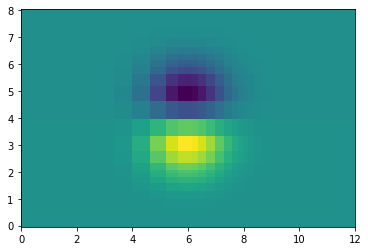

In [48]:
plt.pcolormesh(x_in, y_in,
               proj_2D(weighted_array, 
                       M_x, M_y, npts, quad_weights(GLL_points), coord_x_dist, coord_y_dist).transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts),
               cmap='viridis', shading='auto')

## Solve 2D linear transport equation with CG SEM:

In [49]:
# Determine wind fields for advection; each function outputs two components in Cartesian coordinates:
# Arg shear_array set 1 for constant flow:

# Note: shear_array should be an [M_y, npts] array:
def zonal_wind(M_y, M_x, npts, u_value, shear_array_zonal):
    return_array = np.zeros([M_y, M_x, npts, npts])
    return_array[:, :, :, :] = u_value 
    
    return(return_array * shear_array)
    
# Note: shear_array should be an [npts, M_x] array:
def merid_wind(M_y, M_x, npts, v_value, shear_array_merid):
    return_array = np.zeros([M_y, M_x, npts, npts])
    return_array[:, :, :, :] = v_value
    
    return(return_array * shear_array)

In [134]:
shear_array_zonal = np.sin((np.pi / 4) * y_in[:, 0]).reshape(M_y, 10)
u = shear_array_zonal[:, None, :, None] * np.ones((1, 7, 1, 10)) / 10

ValueError: cannot reshape array of size 36 into shape (6,10)

In [140]:
u = np.zeros([M_y, M_x, npts, npts])
v = np.zeros([M_y, M_x, npts, npts])

u[:,:,:,:] = 0.1

# shear_array_zonal = np.sin((np.pi / 4) * y_in[:, 0]).reshape(M_y, 10)
# u = shear_array_zonal[:, None, :, None] * np.ones((1, 7, 1, 10)) / 10

### CG Strong Operator:

In [52]:
# Compute dot product; apply projection: 

def CG_2D_adv_dx(u, v, array_in, D, M_x, M_y, npts, coord_x_dist, coord_y_dist, quad_weights):
    adv_x = u * proj_2D(grad(array_in, D, M_x, M_y, npts, coord_x_dist, coord_y_dist)[0],
                        M_x, M_y, npts, quad_weights, coord_x_dist, coord_y_dist)
    adv_y = v * proj_2D(grad(array_in, D, M_x, M_y, npts, coord_x_dist, coord_y_dist)[1],
                        M_x, M_y, npts, quad_weights, coord_x_dist, coord_y_dist)
    
    return(adv_x + adv_y)

def CG_2D_conserv_dx(u, v, array_in, D, M_x, M_y, npts, coord_x_dist, coord_y_dist, quad_weights):
    div_flux = div(u * array_in, v * array_in, M_x, M_y, npts, coord_x_dist, coord_y_dist)
    return(proj_2D(div_flux, M_x, M_y, npts, quad_weights, coord_x_dist, coord_y_dist))

### CG Weak Operator:

In [136]:
def weak_CG_2D_conserv_dx(u, v, array_in, D, M_x, M_y, npts, coord_x_dist, coord_y_dist, quad_weights):
    W_array = W_matrix(quad_weights, M_x, M_y, npts, coord_x_dist, coord_y_dist)
    wk_div_flux = weak_div(u * array_in, v * array_in, M_x, M_y, npts, coord_x_dist, coord_y_dist, D, quad_weights)
    return(proj_2D(wk_div_flux / W_array, M_x, M_y, npts, quad_weights, coord_x_dist, coord_y_dist))

### Run 2D Advection:

In [141]:
t_steps = 30
dt = 0.10

init = norm_Gaussian_2d(coords_2d(coord_x, coord_y, npts, M_x, M_y), array_2d(M_x, M_y, npts), 
                       [1, 1], L_x, L_y, M_x, M_y)

for i in np.arange(0, t_steps, dt):
    
    init_mid = np.zeros_like(init)
    init_n = np.zeros_like(init)
    
    # Half time step:
    init_mid = init + ((dt / 2) * weak_CG_2D_conserv_dx(u, v, init, D, M_x, M_y, npts, 
                                                   coord_x_dist, coord_y_dist, quad_weights(GLL_points)))
    # Full time step:
    init_n = init + ((dt) * weak_CG_2D_conserv_dx(u, v, init_mid, D, M_x, M_y, npts, 
                                                  coord_x_dist, coord_y_dist, quad_weights(GLL_points)))
    
    # Prepare for the next timestep:
    init = init_n

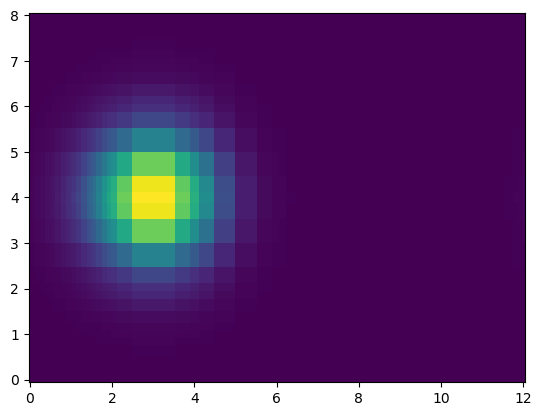

In [142]:
plt.pcolormesh(x_in, y_in,
               init.transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts),
               cmap='viridis', shading='auto')

## Solve 2D linear transport equation with DG SEM:

In [83]:
# Returns a two-component vector:
def transport_analytic_flux(u, v, array_in):
    return(np.array([np.array([u * array_in]), np.array([v * array_in])]))

In [84]:
# Multiplies the Jacobian of map by the contravariant component [0,1] of the vector:
def return_normal(comp_in, j, i, coord_x_dist, coord_y_dist, contra_comp):
    
    J_value = np.linalg.det(d_rmap(j, i, coord_x_dist, coord_y_dist))
    
    return(J_value * np.array([np.matmul(np.linalg.inv(d_rmap(j, i, coord_x_dist, coord_y_dist)), 
                               comp_in[:, :, k])[contra_comp] for k in np.arange(comp_in.shape[-1])]))

In [85]:
# Implement centered flux for DG; expressed in terms of the analytic flux: 
def transport_num_flux(array_1, array_2, u1, v1, u2, v2, 
                       j1, i1, j2, i2, coord_x_dist, coord_y_dist, contra_comp):
    
    n_1 = return_normal(transport_analytic_flux(u1, v1, array_1), j1, i1, coord_x_dist, coord_y_dist, contra_comp)
    n_2 = return_normal(transport_analytic_flux(u2, v2, array_2), j2, i2, coord_x_dist, coord_y_dist, contra_comp)
    return(0.5 * np.squeeze(n_1 + n_2))

In [86]:
def DG_boundary(array_in, u, v, coord_x_dist, coord_y_dist, quad_weights, M_x, M_y, npts):
    
    return_array = np.zeros([2, M_y, M_x, npts, npts]) 
    
    for i in np.arange(M_x):
        i_l = (i - 1) % M_x
        i_r = (i + 1) % M_x
        
        for j in np.arange(M_y):
            j_u = (j - 1) % M_y
            j_d = (j + 1) % M_y 
            
            # Top edge:
            return_array[0, j, i, 0, :] = transport_num_flux(-array_in[j, i, 0, :], array_in[j_u, i, -1, :], 
                                                             u[j, i, 0, :], v[j, i, 0, :], u[j_u, i, -1, :], v[j_u, i, -1, :], 
                                                             j, i, j_u, i, coord_x_dist, coord_y_dist, 1) * quad_weights
            # Bottom edge:
            return_array[0, j, i, -1, :] = transport_num_flux(array_in[j, i, -1, :], -array_in[j_d, i, 0, :], 
                                                              u[j, i, -1, :], v[j, i, -1, :], u[j_d, i, 0, :], v[j_d, i, 0, :], 
                                                              j, i, j_d, i, coord_x_dist, coord_y_dist, 1) * quad_weights
            # Left edge:
            return_array[1, j, i, :, 0] = transport_num_flux(-array_in[j, i, :, 0], array_in[j, i_l, :, -1], 
                                                             u[j, i, :, 0], v[j, i, :, 0], u[j, i_l, :, -1], v[j, i_l, :, -1], 
                                                             j, i, j, i_l, coord_x_dist, coord_y_dist, 0) * quad_weights
            # Right edge: 
            return_array[1, j, i, :, -1] = transport_num_flux(array_in[j, i, :, -1], -array_in[j, i_r, :, 0], 
                                                              u[j, i, :, -1], v[j, i, :, -1], u[j, i_r, :, 0], v[j, i_r, :, 0], 
                                                              j, i, j, i_r, coord_x_dist, coord_y_dist, 0) * quad_weights
            
    return(return_array)


### Unit Test:

In [93]:
# Confirm (Wij * DIV(b)) + WDIV(b) = BI(b) where b is the 2D vector vector for 1 element:

In [147]:
def return_normal(comp_in, j, i, coord_x_dist, coord_y_dist, contra_comp):
    
    J_value = np.linalg.det(d_rmap(j, i, coord_x_dist, coord_y_dist))
    
    return(J_value * np.array([np.matmul(np.linalg.inv(d_rmap(j, i, coord_x_dist, coord_y_dist)), 
                               comp_in[:, :, k])[contra_comp] for k in np.arange(comp_in.shape[-1])]))

In [148]:
# Returns a two-component vector:
def transport_analytic_flux(u, v, array_in):
    return(np.array([np.array([u * array_in]), np.array([v * array_in])]))

In [149]:
# Returns normal of the analytic flux: 
def transport_num_flux(array_1, u1, v1, j1, i1, coord_x_dist, coord_y_dist, contra_comp):
    
    n_1 = return_normal(transport_analytic_flux(u1, v1, array_1), j1, i1, coord_x_dist, coord_y_dist, contra_comp)
    return(np.squeeze(n_1))

In [150]:
def unit_boundary_test(array_in, u, v, coord_x_dist, coord_y_dist, quad_weights, M_x, M_y, npts):
    
    return_array = np.zeros([2, M_y, M_x, npts, npts]) 
    # W_array = W_matrix(quad_weights, M_x, M_y, npts, coord_x_dist, coord_y_dist)
    
    for i in np.arange(M_x):
        i_l = (i - 1) % M_x
        i_r = (i + 1) % M_x
        
        for j in np.arange(M_y):
            j_u = (j - 1) % M_y
            j_d = (j + 1) % M_y 
            
            # Top edge:
            return_array[0, j, i, 0, :] = transport_num_flux(-array_in[j, i, 0, :], u[j, i, 0, :], v[j, i, 0, :],
                                                             j, i, coord_x_dist, coord_y_dist, 1) * quad_weights
            # Bottom edge:
            return_array[0, j, i, -1, :] = transport_num_flux(array_in[j, i, -1, :], u[j, i, -1, :], v[j, i, -1, :], 
                                                              j, i, coord_x_dist, coord_y_dist, 1) * quad_weights
            # Left edge:
            return_array[1, j, i, :, 0] = transport_num_flux(-array_in[j, i, :, 0], u[j, i, :, 0], v[j, i, :, 0], 
                                                             j, i, coord_x_dist, coord_y_dist, 0) * quad_weights
            # Right edge: 
            return_array[1, j, i, :, -1] = transport_num_flux(array_in[j, i, :, -1], u[j, i, :, -1], v[j, i, :, -1], 
                                                              j, i, coord_x_dist, coord_y_dist, 0) * quad_weights
            
    return(return_array)

In [151]:
init = norm_Gaussian_2d(coords_2d(coord_x, coord_y, npts, M_x, M_y), array_2d(M_x, M_y, npts), 
                       [1, 1], L_x, L_y, M_x, M_y)

u = np.zeros((M_y, M_x, npts, npts))
v = np.zeros((M_y, M_x, npts, npts)) 
u[:, :, :, :] = 10
v[:, :, :, :] = 10

term_1 = div(u * init, v * init, M_x, M_y, npts, coord_x_dist, coord_y_dist) * W_matrix(quad_weights(GLL_points), M_x, M_y, npts, coord_x_dist, coord_y_dist)
term_2 = weak_div(u * init, v * init, M_x, M_y, npts, coord_x_dist, coord_y_dist, D, quad_weights(GLL_points)) 
bndy = np.sum(unit_boundary_test(init, u, v, coord_x_dist, coord_y_dist, quad_weights(GLL_points), M_x, M_y, npts), axis = 0)

In [156]:
(term_1 + term_2)[1, 1, :, :] - bndy[1, 1, :, :]

array([[ 5.22534528e-10,  1.59509966e-09,  4.44752767e-09,
         9.36643738e-09,  1.17701740e-08, -1.61153699e-09],
       [ 2.91030833e-09,  2.76849253e-09,  7.64455814e-09,
         1.58658500e-08,  1.97122372e-08, -3.06018264e-08],
       [ 8.24846209e-09,  7.64370067e-09,  2.10983815e-08,
         4.37634103e-08,  5.43484843e-08, -8.74496291e-08],
       [ 1.67590682e-08,  1.50474412e-08,  4.15149941e-08,
         8.60513094e-08,  1.06804469e-07, -1.79386092e-07],
       [ 1.94842658e-08,  1.70134072e-08,  4.69190125e-08,
         9.71895450e-08,  1.20567082e-07, -2.10256718e-07],
       [ 2.42532359e-09, -1.14154561e-08, -3.20588758e-08,
        -6.82341029e-08, -8.64385639e-08, -7.40287759e-08]])

In [ ]:
# Note: The unit test works!

### Solve 2D Linear Transport Equation with DG SEM:

In [143]:
def DG_2D_conserv_dx(array_in, u, v, M_x, M_y, npts, coord_x_dist, coord_y_dist, quad_weights):
    
    flux_x_comp = u * array_in
    flux_y_comp = v * array_in 
    W_array = W_matrix(quad_weights, M_x, M_y, npts, coord_x_dist, coord_y_dist)
    
    int_term = weak_div(flux_x_comp, flux_y_comp, M_x, M_y, npts, coord_x_dist, coord_y_dist, D, quad_weights) / W_array
    boundary_term = np.sum(DG_boundary(init, u, v, coord_x_dist, coord_y_dist, 
                                       quad_weights, M_x, M_y, npts), axis = 0) / W_array
    
    return(int_term - boundary_term)

In [144]:
u = np.zeros((M_y, M_x, npts, npts))
v = np.zeros((M_y, M_x, npts, npts)) 
u[:, :, :, :] = 1

t_steps = 5
dt = 0.05

init = norm_Gaussian_2d(coords_2d(coord_x, coord_y, npts, M_x, M_y), array_2d(M_x, M_y, npts), 
                       [1, 1], L_x, L_y, M_x, M_y)

for i in np.arange(0, t_steps, dt):
    
    init_mid = np.zeros_like(init)
    init_n = np.zeros_like(init)
    
    # Half time step:
    init_mid = init - ((dt / 2) * DG_2D_conserv_dx(init, u, v, M_x, M_y, npts, 
                                                   coord_x_dist, coord_y_dist, quad_weights(GLL_points)))
    # Full time step:
    init_n = init - ((dt) * DG_2D_conserv_dx(init_mid, u, v, M_x, M_y, npts, 
                                             coord_x_dist, coord_y_dist, quad_weights(GLL_points)))
    
    # Prepare for the next timestep:
    init = init_n

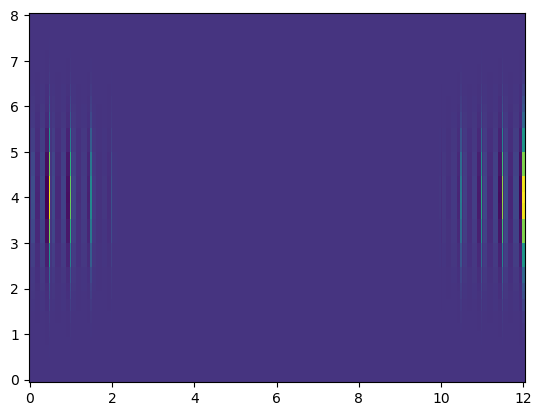

In [145]:
plt.pcolormesh(x_in, y_in,
               init.transpose(0, 2, 1, 3).reshape(M_y * npts, M_x * npts),
               cmap='viridis', shading='auto')

In [146]:
np.max(init)

3.379843107496065e+66

In [109]:
np.max(norm_Gaussian_2d(coords_2d(coord_x, coord_y, npts, M_x, M_y), array_2d(M_x, M_y, npts), 
                       [1, 1], L_x, L_y, M_x, M_y))

0.15915494309189535